### Environment setups and libraries import

In [1]:
!pip install textdescriptives spacy pandas numpy scikit-learn tensorflow shap matplotlib seaborn kagglehub
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 5.7 MB/s eta 0:00:0000:0100:02
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
!pip install --upgrade --force-reinstall numpy pandas 

In [2]:
import pandas as pd
import numpy as np
#import nltk
import kagglehub
import os
import spacy
#from nltk.corpus import stopwords
#from nltk.stem import WordNetLemmatizer
#from nltk.tokenize import word_tokenize
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

### Handle inputs from sources

##### Fetch dataset from KaggleHub and load the full dataset 
- Fetch dataset from KaggleHub.
- Find the CSV file within downloaded dataset.
- Load the full dataset using the correct path.


In [3]:
# Fetch dataset from KaggleHub
dataset_path = kagglehub.dataset_download("shanegerami/ai-vs-human-text")

# Find the CSV file within the downloaded dataset.
csv_file = None
for filename in os.listdir(dataset_path):
    if filename.endswith(".csv"):
        csv_file = filename
        break

if csv_file is None:
    raise FileNotFoundError(f"No CSV file found in the dataset directory: {dataset_path}")

#  Construct the full path to the CSV file
csv_file_path = os.path.join(dataset_path, csv_file)

# Load the full dataset using the correct path
df_ai_human = pd.read_csv(csv_file_path)

##### Seperate AI-generated and Human-written data
- Separates AI-generated and Human-written Data
- Handles Cases with Insufficient Data
- Randomly Samples Data (if sufficient)

In [4]:
# Split df_ai_human into df_ai and df_human
df_ai = df_ai_human[df_ai_human['generated'] == 1]
df_human = df_ai_human[df_ai_human['generated'] == 0]


# Check if number of rows of df_ai is less than 10000
if os.path.exists(csv_file_path):
    df_ai_r = df_ai.sample(n=10000, random_state=42)
    df_human_r = df_human.sample(n=10000, random_state=42)
    df_balanced = pd.concat([df_ai_r, df_human_r]).sample(frac=1, random_state=42).reset_index(drop=True)
    df_balanced.rename(columns={'generated': 'label'}, inplace=True)

##### Set of n stylometric features

In [5]:
# Load spaCy model with textdescriptives
import textdescriptives as td
import spacy

#nlp = spacy.load("en_core_web_sm")
nlp = spacy.load("en_core_web_lg")
nlp.add_pipe("textdescriptives/all")
docs = list(nlp.pipe(df_balanced["text"].astype(str)))
df_features = td.extract_df(docs)
df_final = pd.concat([df_features, df_balanced["label"]], axis=1)

threshold = 0.5  # Set your threshold here
df_final = df_final.dropna(thresh=int(threshold * len(df_final)), axis=1)

print(f"Shape of df_final after handling missing values: {df_final.shape}")

/opt/anaconda3/envs/llms/lib/python3.11/site-packages/textdescriptives/components/coherence.py:44: UserWarning: [W008] Evaluating Span.similarity based on empty vectors.
  similarities.append(sent.similarity(sents[i + order]))


Shape of df_final after handling missing values: (20000, 71)


### Data Processing

### Feature Extraction 

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# ✅ Step 1: Prepare features and labels
# If 'text' column exists, use it for TF-IDF, otherwise use numerical features
"""
if "text" in df_final.columns:
    X = df_final["text"]  # Text data for TF-IDF
    y = df_final["label"]
    
    # Initialize and fit the vectorizer
    vectorizer = TfidfVectorizer(max_features=5000)
    X = vectorizer.fit_transform(X)  # Transform text data
else:
    X = df_final.drop(columns=["label"])  # Numerical features
    y = df_final["label"]
"""
if "text" in df_final.columns:
    X = df_final["text"]  # Text data for TF-IDF
    y = df_final["label"]

    # Find NaN values in X (text data) and y
    #nan_mask_X = X.isna()
    nan_mask_y = y.isna()
    
    #print(nan_mask_X)
    #print(nan_mask_y)

    # Combine the masks to find rows where either X or y is NaN
    nan_mask = nan_mask_y

    # Get the indices of rows with NaN values
    nan_indices = nan_mask[nan_mask].index

    # Drop the rows with NaN values from df_final
    df_final = df_final.drop(nan_indices)

    # Update X and y after dropping rows
    X = df_final["text"]  # Text data for TF-IDF
    y = df_final["label"]

    # Initialize and fit the vectorizer
    vectorizer = TfidfVectorizer(max_features=5000)
    X = vectorizer.fit_transform(X)  # Transform text data

else:
    X = df_final.drop(columns=["label"])  # Numerical features
    y = df_final["label"]

    # Find NaN values in X (numerical features) and y
    nan_mask_X = X.isna().any(axis=1)  # Check for NaNs in any column of each row
    nan_mask_y = y.isna()

    # Combine the masks to find rows where either X or y is NaN
    nan_mask = nan_mask_X | nan_mask_y

    # Get the indices of rows with NaN values
    nan_indices = nan_mask[nan_mask].index

    # Drop the rows with NaN values from df_final
    df_final = df_final.drop(nan_indices)

    # Update X and y after dropping rows
    X = df_final.drop(columns=["label"])  # Numerical features
    y = df_final["label"]


# ✅ Step 2: First, split 80% for training, 20% temp (which we'll further split into val/test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ✅ Step 3: Split the 20% temp into 50% val, 50% test → each gets 10% of total data
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# If you have numerical features alongside text, scale them
if "text" in df_final.columns:
    # No scaling needed for TF-IDF output directly
    pass
else:
    # ✅ Step 4: Normalize features using StandardScaler (if not using text)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)


# ✅ Confirm sizes
print(f"✅ Training: {X_train.shape[0]} samples")
print(f"✅ Validation: {X_val.shape[0]} samples")
print(f"✅ Testing: {X_test.shape[0]} samples")

✅ Training: 16000 samples
✅ Validation: 2000 samples
✅ Testing: 2000 samples


### Classifier Training

✅ Validation Accuracy: 0.9740
✅ Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97      1000
         1.0       0.99      0.96      0.97      1000

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000

✅ Test Accuracy: 0.9765
✅ Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98      1000
         1.0       0.99      0.96      0.98      1000

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



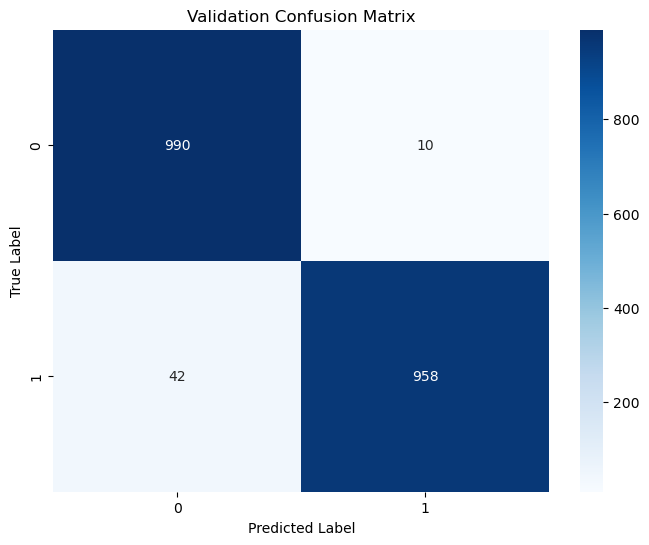

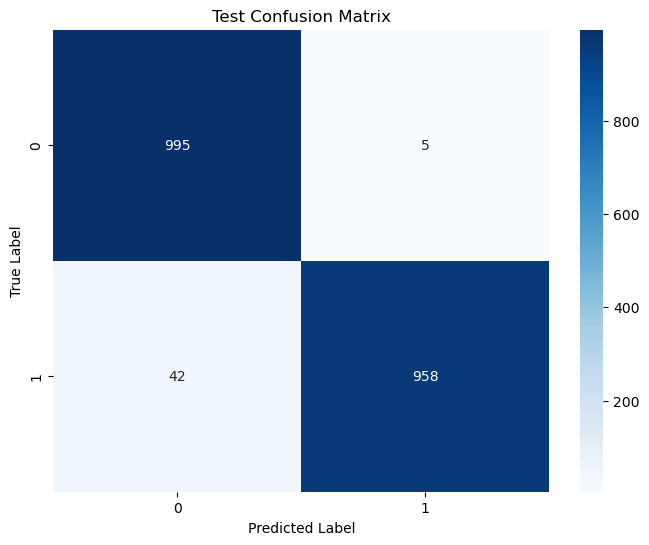

In [7]:
# This code blocks splits the data into training and testing sets.
#
# X: The feature matrix (independent variables).
# y: The target variable (dependent variable).
#
# Keyword Arguments:
#   test_size=0.2:  Specifies that 20% of the data should be used for the test set,
#                   and the remaining 80% for the training set.
#   random_state=42: Sets the seed for the random number generator, ensuring that the
#                    split is reproducible.  Using the same random_state will always
#                    result in the same train/test split.
#   stratify=y:     Performs stratified splitting, maintaining the same class proportions
#                    in both the training and testing sets as in the original dataset.
#                    This is particularly important for imbalanced datasets to ensure
#                    that the test set is representative of all classes.
#
# Returns:
#   x_train: Feature matrix for the training set.
#   x_test:  Feature matrix for the test set.
#   y_train: Target variable for the training set.
#   y_test:  Target variable for the test set.
# ✅ Step 6: Train RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, criterion="gini")  # You can adjust hyperparameters
rf_classifier.fit(X_train, y_train)

# ✅ Step 7: Evaluate the model
y_pred = rf_classifier.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"✅ Validation Accuracy: {accuracy:.4f}")

# ✅ Step 8: Print Classification Report
print("✅ Classification Report:")
print(classification_report(y_val, y_pred))

# ✅ Step 9: Evaluate on the test set
y_test_pred = rf_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"✅ Test Accuracy: {test_accuracy:.4f}")
print("✅ Test Classification Report:")
print(classification_report(y_test, y_test_pred))

# ✅ Step 10: Plot Confusion Matrix for Validation Set
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Validation Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# ✅ Step 11: Plot Confusion Matrix for Test Set
cm_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues")
plt.title("Test Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()